In [1]:
import sys 
sys.path.append('../data') 

from graphics import simulate_8qam_constellation
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def rrc_filter(beta, sps, num_taps):
    """Genera un filtro de Coseno Elevado Raíz (RRC)."""
    t = np.arange(-num_taps // 2, num_taps // 2 + 1) / sps
    pi_t = np.pi * t
    four_beta_t = 4 * beta * t

    with np.errstate(divide="ignore", invalid="ignore"):
        numerator = np.sin(pi_t * (1 - beta)) + 4 * beta * t * np.cos(pi_t * (1 + beta))
        denominator = pi_t * (1 - (four_beta_t) ** 2)
        h = numerator / denominator

    # Manejo de t = 0
    h[np.isnan(h)] = 1.0 - beta + (4 * beta / np.pi)
    # Manejo de t = ±1/(4β)
    t_special = np.abs(t) == (1 / (4 * beta))
    h[t_special] = (beta / np.sqrt(2)) * (
        ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)))
        + ((1 - 2 / np.pi) * np.cos(np.pi / (4 * beta)))
    )

    # Normalizar el filtro
    h /= np.sqrt(np.sum(h**2))

    return h

def bits_to_8qam_symbols(bits):
    bits = np.array(bits)
    # Asegurar que la longitud de bits sea múltiplo de 3
    num_bits = len(bits)
    num_symbols = num_bits // 3
    bits = bits[:num_symbols * 3]
    bits_reshaped = bits.reshape((num_symbols, 3))
    
    # Definir mapeo de símbolos
    symbol_mapping = {
        (0, 0, 0): (-1 - 1j) / np.sqrt(3),
        (0, 0, 1): (-1 + 1j) / np.sqrt(3),
        (0, 1, 0): (1 - 1j) / np.sqrt(3),
        (0, 1, 1): (1 + 1j) / np.sqrt(3),
        (1, 0, 0): (-2 + 0j) / np.sqrt(5),
        (1, 0, 1): (0 + 2j) / np.sqrt(5),
        (1, 1, 0): (2 + 0j) / np.sqrt(5),
        (1, 1, 1): (0 - 2j) / np.sqrt(5),
    }
    symbols = []
    for b in bits_reshaped:
        b_tuple = tuple(b)
        symbol = symbol_mapping[b_tuple]
        symbols.append(symbol)
    symbols = np.array(symbols)
    return symbols

def normalize_signal(signal):
    """Normaliza la señal a la unidad."""
    return signal / np.max(np.abs(signal))


def preamble_detection(signal, preamble_symbols, sps):
    # Filtrar la señal recibida
    rrc_coef = rrc_filter(beta, sps, num_taps)
    matched_filtered_signal = np.convolve(signal, rrc_coef, mode='same')

    # Sobremuestrear el preámbulo
    preamble_upsampled = np.zeros(len(preamble_symbols) * sps, dtype=complex)
    preamble_upsampled[::sps] = preamble_symbols

    # Filtrar el preámbulo
    preamble_filtered = np.convolve(preamble_upsampled, rrc_coef, mode='same')

    # Estimación de desplazamiento de frecuencia utilizando el período del preámbulo
    corr = np.correlate(matched_filtered_signal, preamble_filtered, mode='valid')
    peak_index = np.argmax(np.abs(corr))
    freq_offset_est = np.angle(corr[peak_index]) / (2 * np.pi * peak_index)

    # Corregir el desplazamiento de frecuencia
    t = np.arange(len(matched_filtered_signal))
    matched_filtered_signal *= np.exp(-1j * 2 * np.pi * freq_offset_est * t)

    # Recalcular la correlación cruzada después de la corrección
    corr = np.correlate(matched_filtered_signal, preamble_filtered, mode='valid')
    peak_index = np.argmax(np.abs(corr))

    return peak_index, matched_filtered_signal

def demodulate_8qam(symbols):
    # Definir constelación
    constellation = np.array([
        (-1 - 1j) / np.sqrt(3),
        (-1 + 1j) / np.sqrt(3),
        (1 - 1j) / np.sqrt(3),
        (1 + 1j) / np.sqrt(3),
        (-2 + 0j) / np.sqrt(5),
        (0 + 2j) / np.sqrt(5),
        (2 + 0j) / np.sqrt(5),
        (0 - 2j) / np.sqrt(5),
    ])
    # Mapear símbolos a bits
    bits_mapping = [
        (0, 0, 0),
        (0, 0, 1),
        (0, 1, 0),
        (0, 1, 1),
        (1, 0, 0),
        (1, 0, 1),
        (1, 1, 0),
        (1, 1, 1),
    ]
    received_bits = []
    for symbol in symbols:
        distances = np.abs(symbol - constellation)
        index = np.argmin(distances)
        bits = bits_mapping[index]
        received_bits.extend(bits)
    return np.array(received_bits)

def costas_loop_8qam(signal, alpha=0.01, beta=0.0001):
    N = len(signal)
    phase = 0
    freq = 0
    out = np.zeros(N, dtype=np.complex128)
    constellation = np.array([
        (-1 - 1j) / np.sqrt(3),
        (-1 + 1j) / np.sqrt(3),
        (1 - 1j) / np.sqrt(3),
        (1 + 1j) / np.sqrt(3),
        (-2 + 0j) / np.sqrt(5),
        (0 + 2j) / np.sqrt(5),
        (2 + 0j) / np.sqrt(5),
        (0 - 2j) / np.sqrt(5),
    ])
    for i in range(N):
        # Remover la fase estimada
        out[i] = signal[i] * np.exp(-1j * phase)
        # Demodulación de decisión dirigida
        distances = np.abs(out[i] - constellation)
        index = np.argmin(distances)
        decision = constellation[index]
        # Calcular el error de fase
        error = np.angle(out[i] * np.conj(decision))
        freq += beta * error
        phase += freq + alpha * error
    return out

def gardner_timing_recovery(signal, sps):
    mu = 0.0  # Fase de temporización inicial
    out = []
    i_in = 0
    while i_in + sps < len(signal):
        # Muestras necesarias
        sample1 = signal[int(i_in + mu)]
        sample2 = signal[int(i_in + mu + sps / 2)]
        sample3 = signal[int(i_in + mu + sps)]
        # Cálculo del error de Gardner
        error = (np.real(sample1) - np.real(sample3)) * np.real(sample2) + (np.imag(sample1) - np.imag(sample3)) * np.imag(sample2)
        # Actualizar mu
        mu += -error * 0.01  # Ajusta la ganancia según sea necesario
        # Asegurar que mu se mantenga dentro de los límites
        if mu < -sps / 2:
            mu += sps / 2
            i_in += sps / 2
        elif mu > sps / 2:
            mu -= sps / 2
            i_in += sps / 2
        else:
            i_in += sps / 2
        out.append(sample1)
    return np.array(out)

def channel_decode(bits, repetition=3):
    bits = bits[: len(bits) - len(bits) % repetition]  # Ajustar longitud
    bits_reshaped = bits.reshape(-1, repetition)
    decoded_bits = (np.sum(bits_reshaped, axis=1) > (repetition / 2)).astype(np.uint8)
    return decoded_bits

def channel_encode(bits, repetition=3):
    return np.repeat(bits, repetition)

In [3]:
# Parámetros de configuración
samples_per_symbol = 8  # Muestras por símbolo
beta = 0.95  # Factor de roll-off del filtro RRC
num_taps = 151  # Número de taps del filtro RRC
snr_db = 30  # Relación señal a ruido en dB

# Desfase y CFO
phase_offset = np.pi / 6  # Desfase de 30 grados
frequency_offset = 0.005  # Desplazamiento de frecuencia normalizado

# Semilla aleatoria para reproducibilidad
np.random.seed(0)

# Generar preámbulo compatible con 8-QAM
preamble_bits = np.array([
    0, 0, 0,
    0, 0, 1,
    0, 1, 0,
    0, 1, 1,
    1, 0, 0,
    1, 0, 1,
    1, 1, 0,
    1, 1, 1
])
np.save('../data/preamble_bits_simulation.npy', preamble_bits)
preamble_symbols = bits_to_8qam_symbols(preamble_bits)
print(f"Preamble symbols: {preamble_symbols}")

# Cargar imagen y convertir a bits
image = Image.open('../images/imagen3.jpg')
image = image.convert('RGB')  # Mantener la imagen en color RGB
width, height = image.size
image_array = np.array(image)
image_flat = image_array.flatten()
image_bits = np.unpackbits(image_flat)
print(f"Imagen cargada: {width}x{height} píxeles.")

# Codificar los bits de imagen
encoded_bits = channel_encode(image_bits, repetition=3)

# Crear encabezado con el tamaño de la imagen
width_bytes = np.array([width], dtype='>u2').view(np.uint8)
height_bytes = np.array([height], dtype='>u2').view(np.uint8)
width_bits = np.unpackbits(width_bytes)
height_bits = np.unpackbits(height_bytes)
header_bits = np.concatenate((width_bits, height_bits))

# Codificar el encabezado
encoded_header_bits = channel_encode(header_bits, repetition=3)

# Concatenar preámbulo, encabezado y bits de imagen
bits = np.concatenate((preamble_bits, encoded_header_bits, encoded_bits))

# Asegurar que la longitud de bits sea múltiplo de 3
extra_bits = (3 - (len(bits) % 3)) % 3
bits = np.concatenate((bits, np.zeros(extra_bits, dtype=np.uint8)))

# Guardar bits transmitidos para comparación en el receptor
np.save('../data/transmitted_bits_simulation.npy', bits)

# Mapear bits a símbolos 8-QAM
symbols = bits_to_8qam_symbols(bits)

# Sobremuestrear símbolos
symbols_upsampled = np.zeros(len(symbols) * samples_per_symbol, dtype=complex)
symbols_upsampled[::samples_per_symbol] = symbols

# Generar filtro RRC
rrc_coef = rrc_filter(beta, samples_per_symbol, num_taps)

# Filtrar la señal (conformación de pulsos)
signal_filtered = np.convolve(symbols_upsampled, rrc_coef, mode='same')

# Normalizar amplitud de la señal
signal_filtered /= np.max(np.abs(signal_filtered))

# Aplicar desfase y CFO (simular canal inalámbrico con desplazamiento de frecuencia y fase)
sample_rate = int(1e6)  # Tasa de muestreo normalizada
t = np.arange(len(signal_filtered)) / sample_rate
signal_complex = signal_filtered * np.exp(1j * (2 * np.pi * frequency_offset * t + phase_offset))


Preamble symbols: [-0.57735027-0.57735027j -0.57735027+0.57735027j  0.57735027-0.57735027j
  0.57735027+0.57735027j -0.89442719+0.j          0.        +0.89442719j
  0.89442719+0.j          0.        -0.89442719j]
Imagen cargada: 600x400 píxeles.


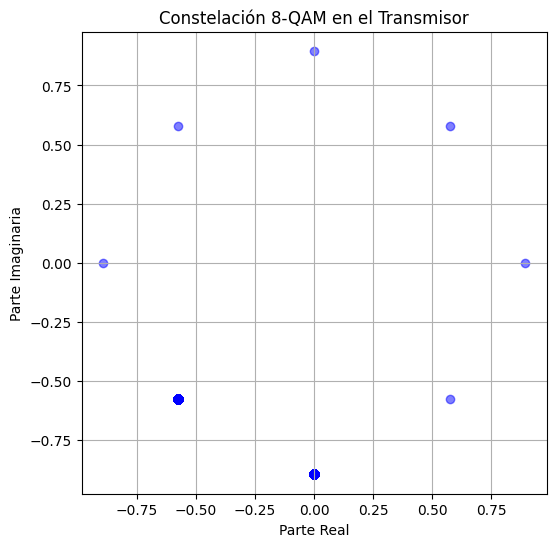

In [4]:
# Visualización de la constelación antes de la transmisión (antes del canal)
plt.figure(figsize=(6,6))
plt.scatter(np.real(symbols), np.imag(symbols), color='blue', alpha=0.5)
plt.title('Constelación 8-QAM en el Transmisor')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.axis('equal')
plt.show()

In [5]:
# Simular transmisión sobre un canal AWGN
def simulate_transmission(signal, snr_db):
    """Simula la transmisión sobre un canal AWGN."""
    # Calcular potencia de señal y ruido
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear

    # Generar ruido blanco gaussiano
    noise = np.sqrt(noise_power / 2) * (
        np.random.randn(len(signal)) + 1j * np.random.randn(len(signal))
    )

    # Añadir ruido a la señal
    received_signal = signal + noise
    return received_signal

received_signal = simulate_transmission(signal_complex, snr_db)

# Guardar la señal recibida para el receptor
np.save('../data/received_signal_simulation.npy', received_signal)

print("Simulación de transmisión completa. Señal guardada para el procesamiento del receptor.")


Simulación de transmisión completa. Señal guardada para el procesamiento del receptor.


Bits de preámbulo: [-0.57735027-0.57735027j -0.57735027+0.57735027j  0.57735027-0.57735027j
  0.57735027+0.57735027j -0.89442719+0.j          0.        +0.89442719j
  0.89442719+0.j          0.        -0.89442719j]


/var/folders/26/2j5v5y394q7fg0m_5hxsv0w80000gp/T/ipykernel_82549/982471323.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  freq_offset_est = np.angle(corr[peak_index]) / (2 * np.pi * peak_index)
/var/folders/26/2j5v5y394q7fg0m_5hxsv0w80000gp/T/ipykernel_82549/982471323.py:77: RuntimeWarning: invalid value encountered in multiply
  matched_filtered_signal *= np.exp(-1j * 2 * np.pi * freq_offset_est * t)


Preámbulo detectado en el índice: 0


/Users/Jorge/UNSA/redes-inalambricas/proyecto/simulacion/../data/graphics.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


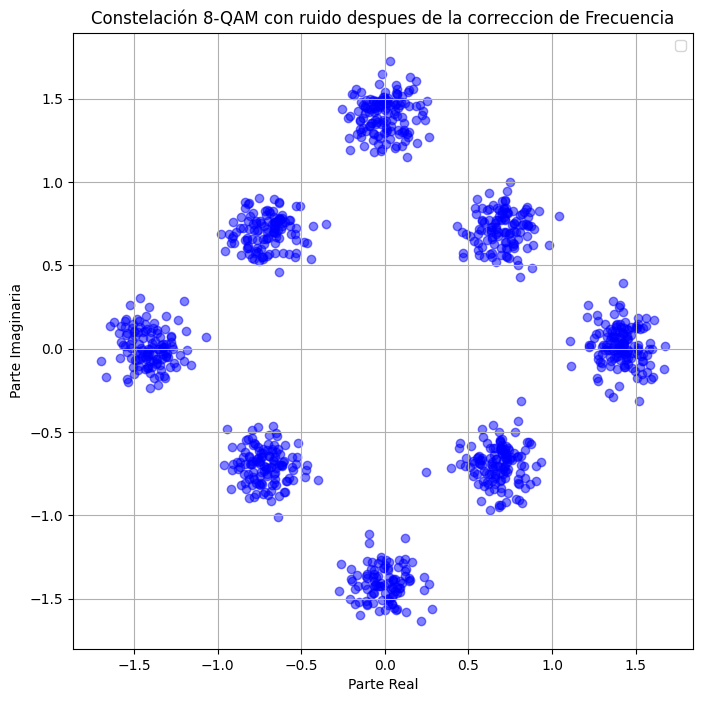

Ancho de imagen: 600, Alto de imagen: 400


In [6]:
samples_per_symbol = 8
beta = 0.95
num_taps = 151
sample_rate = int(5e6)  

# Cargar señal recibida
received_signal = np.load('../data/received_signal_simulation.npy')
preamble_bits = np.array([
    0, 0, 0,
    0, 0, 1,
    0, 1, 0,
    0, 1, 1,
    1, 0, 0,
    1, 0, 1,
    1, 1, 0,
    1, 1, 1
])
preamble_symbols = bits_to_8qam_symbols(preamble_bits)
print(f"Bits de preámbulo: {preamble_symbols}")
# Detección de preámbulo usando correlación
d_max, matched_filtered_signal = preamble_detection(received_signal, preamble_symbols, samples_per_symbol)
print(f"Preámbulo detectado en el índice: {d_max}")

# Recuperación de fase y frecuencia
frequency_corrected_signal = costas_loop_8qam(matched_filtered_signal)
# Visualización de la constelación después de la sincronización fina de frecuencia
# Graficar la constelación
simulate_8qam_constellation(frequency_corrected_signal)
# Demodulación
# Después de la salida del bucle de Costas
received_symbols = frequency_corrected_signal

# Extraer los símbolos del preámbulo recibidos
received_preamble_symbols = received_symbols[:len(preamble_symbols)]

# Calcular la diferencia de fase entre los símbolos recibidos y los transmitidos
phase_differences = np.angle(received_preamble_symbols * np.conj(preamble_symbols))

# Calcular la diferencia de fase promedio
avg_phase_difference = np.mean(phase_differences)

# Corregir la rotación de fase residual en toda la señal recibida
frequency_corrected_signal *= np.exp(-1j * avg_phase_difference)

# Ahora procedemos con la demodulación
received_symbols = frequency_corrected_signal
received_bits = demodulate_8qam(received_symbols)

# Eliminar posibles bits adicionales
transmitted_bits = np.load('../data/transmitted_bits_simulation.npy')
received_bits = received_bits[:len(transmitted_bits)]

# Extraer los bits del preámbulo recibidos
preamble_received_bits = received_bits[:len(preamble_bits)]

# Verificación del preámbulo
preamble_match = np.array_equal(preamble_received_bits, preamble_bits)
# Ahora aplicar la decodificación de canal al resto de los bits
received_bits_rest = received_bits[len(preamble_bits):]
decoded_bits_rest = channel_decode(received_bits_rest, repetition=3)

# Concatenar los bits decodificados
decoded_bits = np.concatenate((preamble_bits, decoded_bits_rest))

# Extraer y decodificar el encabezado
header_bits = decoded_bits[len(preamble_bits):len(preamble_bits) + 32]
width_bits = header_bits[:16]
height_bits = header_bits[16:32]

# Convertir bits a bytes
width_bytes = np.packbits(width_bits)
height_bytes = np.packbits(height_bits)

# Convertir bytes a enteros de 16 bits
width_tx = int(np.frombuffer(width_bytes.tobytes(), dtype='>u2')[0])
height_tx = int(np.frombuffer(height_bytes.tobytes(), dtype='>u2')[0])

print(f"Ancho de imagen: {width}, Alto de imagen: {height}")

# Extraer bits de imagen
image_bits_tx = decoded_bits[len(preamble_bits) + 32:]
# Ajustar longitud
expected_bits = width * height * 3 * 8  # 3 canales (RGB), 8 bits por canal
image_bits_tx = image_bits_tx[:expected_bits]

# Convertir bits a bytes
image_bytes = np.packbits(image_bits_tx)
# Convertir bytes a matriz de imagen
image_array_tx = np.reshape(image_bytes, (height, width, 3))
# Crear y mostrar la imagen
image = Image.fromarray(image_array, 'RGB')
image.show()

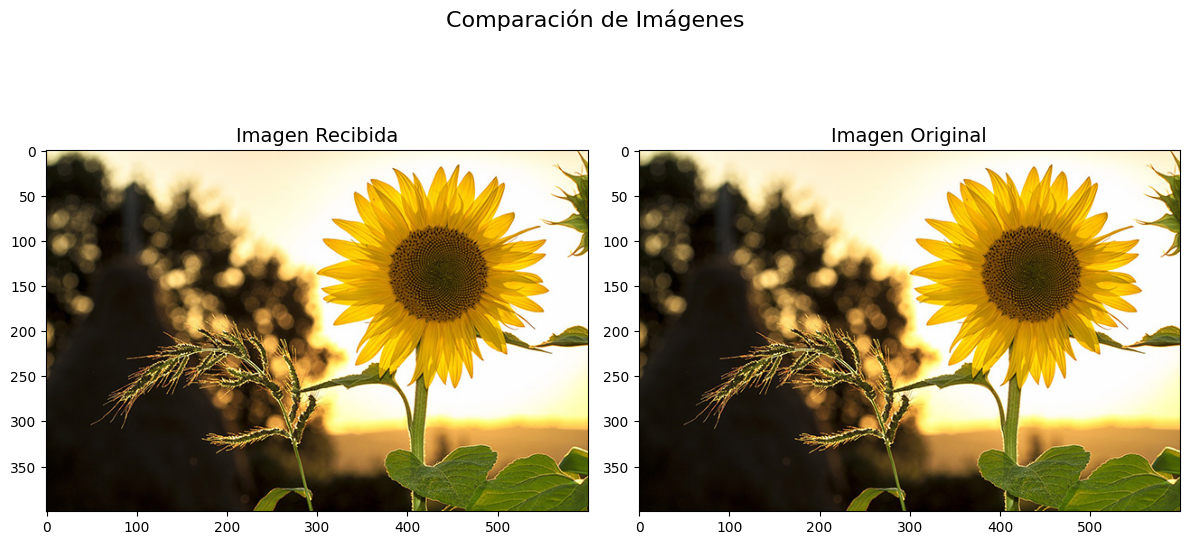

In [7]:
# Mostrar la imagen original y la recibida para comparación usando matplotlib
plt.figure(figsize=(12, 6))
plt.suptitle('Comparación de Imágenes', fontsize=16)

# Imagen recibida
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title('Imagen Recibida', fontsize=14)

# Cargar la imagen original
image_original = Image.open('../images/imagen3.jpg')
image_original = image_original.convert('RGB')
plt.subplot(1, 2, 2)
plt.imshow(image_original)
plt.title('Imagen Original', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar diseño y dejar espacio para el título
plt.show()